In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [23]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.stats.proportion as proportion
import matplotlib.pyplot as plt
import seaborn as sns


def get_95_ci(x1, x2):
    """Calculate a 95% CI for 2 1d numpy arrays"""
    signal = x1.mean() - x2.mean()
    noise = np.sqrt(x1.var() / x1.size + x2.var() / x2.size)

    ci_lo = signal - 1.96 * noise
    ci_hi = signal + 1.96 * noise

    return ci_lo, ci_hi


%matplotlib inline

<IPython.core.display.Javascript object>

# The setup

* You are a data scientist at a luxury jelly e-commerce retailer. In hopes of generating a recurring revenue stream, the retailer has decided to roll out a “Jelly of the Month Club.”
* The retailer is testing whether introducing a testimonial from Clark Griswold on the sidebar of the webpage will increase conversions to the Jelly of the Month Club.
* We will also test to see if, during the experiment, purchase amount increased due to the sidebar testimonial.

<img src='https://i0.wp.com/scng-dash.digitalfirstmedia.com/wp-content/uploads/2019/11/LDN-L-CHEVYCHASE-1124-02.jpg?fit=620%2C9999px&ssl=1' width='20%'>
<center>"I love this luxury jelly" - Clark Griswold... prolly</center>

In [3]:
# Below package is needed for pandas to read xl files
#!pip install xlrd
data_url = "https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/a-b-testing-drill-start-06-14-19.xlsx"

<IPython.core.display.Javascript object>

* Read the data into pandas

In [4]:
df = pd.read_excel(data_url)
df.head()

,trans_id,group,cart_amount,convert
0,176890,treatment,49.46,1
1,443058,treatment,49.34,1
2,827633,treatment,44.08,1
3,277331,treatment,47.16,1
4,843324,treatment,44.19,1


<IPython.core.display.Javascript object>

In [6]:
df.shape

(1780, 4)

<IPython.core.display.Javascript object>

In [8]:
df.dtypes

trans_id         int64
group           object
cart_amount    float64
convert          int64
dtype: object

<IPython.core.display.Javascript object>

In [5]:
df.isna().sum()

trans_id       0
group          0
cart_amount    0
convert        0
dtype: int64

<IPython.core.display.Javascript object>

In [13]:
df.groupby("group").count()

,trans_id,cart_amount,convert
group,,,
control,846,846,846
treatment,934,934,934


<IPython.core.display.Javascript object>

In [14]:
df["group"].value_counts()

treatment    934
control      846
Name: group, dtype: int64

<IPython.core.display.Javascript object>

In [15]:
df["cart_amount"].describe()

count    1780.000000
mean       45.929433
std         2.370880
min        37.110000
25%        44.370000
50%        45.960000
75%        47.470000
max        53.880000
Name: cart_amount, dtype: float64

<IPython.core.display.Javascript object>

In [16]:
df["convert"].mean()

0.051685393258426963

<IPython.core.display.Javascript object>

## Test for treatment's effect on `'cart_amount'`

* Separate the 2 groups into 2 separate DataFrames.

In [17]:
treatment = df[df["group"] == "treatment"]
control = df[df["group"] == "control"]

<IPython.core.display.Javascript object>

* Do we meet the assumptions for a t-test?

In [ ]:
# Assumptions
# Continuous?      yes
# Independent?     think so
# Random sample?   think so
# Normal? yes


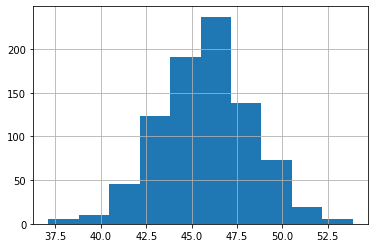

DescribeResult(nobs=846, minmax=(37.11, 53.88), mean=45.76147754137116, variance=6.353660654524599, skewness=-0.03752723142075534, kurtosis=0.07031665647793384)

<IPython.core.display.Javascript object>

In [19]:
control["cart_amount"].hist()
plt.show()
stats.describe(control["cart_amount"])

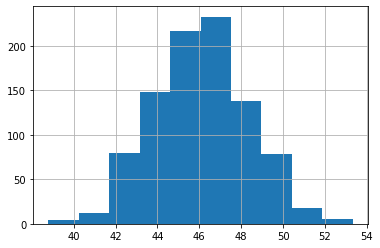

DescribeResult(nobs=934, minmax=(38.79, 53.33), mean=46.08156316916488, variance=4.914859933304416, skewness=0.07382464824639066, kurtosis=-0.07806866468127271)

<IPython.core.display.Javascript object>

In [18]:
treatment["cart_amount"].hist()
plt.show()
stats.describe(treatment["cart_amount"])

* If we meet the assumptions, perform the analysis with a t-test. Does the group have an effect on `'cart_amount'`?

In [20]:
stats.ttest_ind(treatment["cart_amount"], control["cart_amount"])

Ttest_indResult(statistic=2.850184420619994, pvalue=0.004419762574245763)

<IPython.core.display.Javascript object>

In [21]:
get_95_ci(treatment["cart_amount"], control["cart_amount"])

(0.0985761443332894, 0.5415951112541858)

<IPython.core.display.Javascript object>

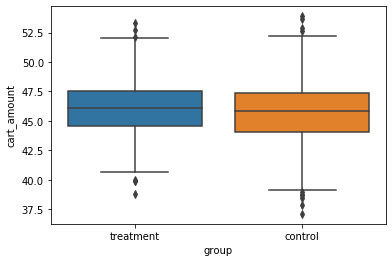

<IPython.core.display.Javascript object>

In [24]:
sns.boxplot("group", "cart_amount", data=df)

## Test for treatment's effect on `'convert'`

* [x] Separate the 2 groups into 2 separate DataFrames (already did this in last step)
* [ ] Do we meet the assumptions for a t-test?


In [ ]:
# Assumptions
# Continuous?      no, binary
# Independent?     yep, think so
# Random sample?   yep, think so
# Normal?          no, binary


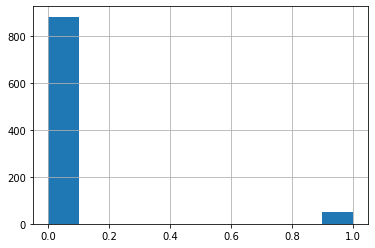

DescribeResult(nobs=1780, minmax=(0, 1), mean=0.051685393258426963, variance=0.04904156482306056, skewness=4.0499788217501544, kurtosis=14.402328456624758)

<IPython.core.display.Javascript object>

In [25]:
treatment["convert"].hist()
plt.show()

stats.describe(df["convert"])

> Because the sample is a proportion, we know more about their distributions than the t-test assumes. Specifically, the distribution of the mean is normal, meaning we could use something called a two sample proportional z-test. We haven't covered this test yet, but you can read about it [here](https://newonlinecourses.science.psu.edu/stat414/node/268/). Find a python implementation for this test and go back and revise our testing. What difference does our new test make?

We'll use [`proportions_ztest`](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) from `statsmodels`.  Below is a snippet from the documentation.

> ```
> Parameters
> ----------
> count : integer or array_like
>     the number of successes in nobs trials. If this is array_like, then
>     the assumption is that this represents the number of successes for
>     each independent sample
> nobs : integer or array-like
>     the number of trials or observations, with the same length as
>     count.
> ```

Our hypotheses are listed below:

* $H_o$: The 2 proportions are the same
* $H_a$: The 2 proportions are not the same

For these proportions, we need a count of the 'successes' for each group and a number of the 'trials' for each group.  How can we calculate that with `pandas`?

* Calculate the numbers that we need to run `proportions_ztest()`

In [28]:
pd.crosstab(df["group"], df["convert"], margins=True)

convert,0,1,All
group,,,
control,804,42,846
treatment,884,50,934
All,1688,92,1780


<IPython.core.display.Javascript object>

In [26]:
df.groupby("group").agg({"convert": ["size", "sum"]})

convert    
             size sum
group                
control       846  42
treatment     934  50

<IPython.core.display.Javascript object>

In [29]:
agg_df = df.groupby("group").agg({"convert": ["size", "sum"]})

<IPython.core.display.Javascript object>

In [31]:
count = agg_df.iloc[:, 1]
nobs = agg_df.iloc[:, 0]

<IPython.core.display.Javascript object>

* Perform the hypothesis test and report your conclusions

In [32]:
z, p_value = proportion.proportions_ztest(count, nobs)
p_value

0.7113883723113998

<IPython.core.display.Javascript object>

In [ ]:
#p is <0.05
#Testimonial does not appear to effect the conversion rate

More on proportions z-test:

* [Nice intro walkthrough](https://www.youtube.com/watch?v=_58qBy9Uxks)
* ["Use and misuse"](https://influentialpoints.com/Training/z-test_for_independent_proportions_use_and_misuse.htm)
* [Python walkthrough (including confidence interval)](http://ethen8181.github.io/machine-learning/ab_tests/frequentist_ab_test.html#Comparing-Two-Proportions)

Another potential test is [`proportions_chisquare()`](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_chisquare.html) from `statsmodels`.  It takes the same arguments.  Below is an excerpt of documentation from `proportions_ztest`.

> In the one and two sample cases with two-sided alternative, this test produces the same p-value as proportions_chisquare, since the chisquare is the distribution of the square of a standard normal distribution.

Translation:

The proportion z-test works for 2 samples, the chi square is an extension of this test to work for >2 samples.  When the number of samples is 2.  These tests work the same.

So in this case, these 2 functions should function the same.

In [33]:
chi2, p_value, expected = proportion.proportions_chisquare(count, nobs)
p_value

0.7113883723113994

<IPython.core.display.Javascript object>

Yet another potential way to beat this horse.

Calculate summary statistics for the `'convert'` column.

In [34]:
df.groupby("group").agg({"convert": ["size", "sum", "mean"]})

convert              
             size sum      mean
group                          
control       846  42  0.049645
treatment     934  50  0.053533

<IPython.core.display.Javascript object>

In [36]:
control_converts = control["convert"].sum()
control_n = control["convert"].size
control_rate = control["convert"].mean()

<IPython.core.display.Javascript object>

In [37]:
treatment_converts = treatment["convert"].sum()
treatment_n = treatment["convert"].size
treatment_rate = treatment["convert"].mean()

<IPython.core.display.Javascript object>

Plot the binomial distribution that corresponds to the control group conversion rate.

Evaluate the probability of getting the result from the test group B based on the binomial distribution from the control group, plot the result.

In [38]:
# Calculate coordinates to plot the corresponding binomial dist

# Create a range of potential number of conversions
# Observed number plus/minus a buffer
x = range(control_converts - 50, control_converts + 50)

# This needs as arguments:
#    * nobs for control
#    * conversion rate for control
y = stats.binom(control_n, control_rate).pmf(x)

<IPython.core.display.Javascript object>

In [39]:
# If the treatment had the same number of people.
# Calculate what the number of conversions would be
# with the treatment's conversion rate.
treatment_converts = control_n * treatment_rate

<IPython.core.display.Javascript object>

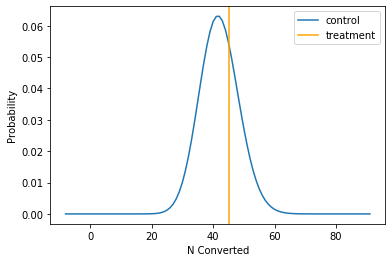

<IPython.core.display.Javascript object>

In [40]:
# Plot x by y and give this a label of 'Control'
plt.plot(x, y, label="control")

# Add a vertical line where where the number
# of conversions would be if we had the treatment
# conversion rate. Label as treatment
plt.axvline(treatment_converts, label="treatment", c="orange")

plt.xlabel("N Converted")
plt.ylabel("Probability")
plt.legend()
plt.show()

Calculate the probability of obtaining the value at our vertical line (i.e. calculate the `y` of the distribution given a single `x`)

In [44]:
#pmf is probability mass function
#Whats the 'mass' (value) of probability at this given point
stats.binom(control_n, control_rate).pmf(int(treatment_converts))

0.05463496954575345

<IPython.core.display.Javascript object>

In [45]:
stats.binom(control_n, control_rate).cdf(int(treatment_converts))

0.7158003154680659

<IPython.core.display.Javascript object>